In [1]:
# imports
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
# np.set_printoptions(suppress=True)
plt.rcParams["axes.formatter.limits"] = (-5, 12)
# pd.options.display.float_format = '{:.2f}'.format

# plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

# Acquire

In [2]:
# load data into a pandas data frame
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Prepare

In [3]:
type(df)

pandas.core.frame.DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.shape

(6435, 8)

In [6]:
# Look for empty values
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## Takeaways 
- There are 6435 records 
- 8 Columns
- There are 0 empty values
- Columns have a mix of upper and lower case characters
    - We will turn them to lower case for 

In [7]:
# Chanege CPI for Consumer Price Index
df.rename(columns={'CPI':'Consumer_Price_Index'}, inplace=True)


In [8]:
# Turn the name of the columns to only contain lower case characters
df.columns= df.columns.str.lower()
df.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_price', 'consumer_price_index', 'unemployment'],
      dtype='object')

In [9]:
#  Ensure data  has the proper columns
df.sample()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
4836,34,04-05-2012,991104.4,0,65.04,3.747,131.136,9.575


In [10]:
# Convert our date column from object type to DateTime type
df.date = pd.to_datetime(df.date, format='%d-%m-%Y')
df.dtypes

store                            int64
date                    datetime64[ns]
weekly_sales                   float64
holiday_flag                     int64
temperature                    float64
fuel_price                     float64
consumer_price_index           float64
unemployment                   float64
dtype: object

In [11]:
# Set the date as index
df = df.set_index('date', drop=True).sort_index()


# Exploratory Analysis

In [12]:
df.weekly_sales.mean()

1046964.8775617704

In [13]:
df.weekly_sales.median()

960746.04

In [14]:
df.index.nunique() # number of unique sales dates

143

In [15]:
# See the full data set
from IPython.display import HTML

HTML(df.to_html())

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-05,10,2193048.75,0,54.34,2.962,126.442065,9.765
2010-02-05,37,536006.73,0,45.97,2.572,209.852966,8.554
2010-02-05,17,789036.02,0,23.11,2.666,126.442065,6.548
2010-02-05,30,465108.52,0,39.05,2.572,210.752605,8.324
2010-02-05,25,677231.63,0,21.10,2.784,204.247194,8.187
2010-02-05,22,1033017.37,0,24.36,2.788,135.352461,8.283
2010-02-05,23,1364721.58,0,15.25,2.788,131.527903,5.892
2010-02-05,24,1388725.63,0,22.43,2.954,131.527903,8.326


In [16]:
# what dates does your data set cover
df.index.min(), df.index.max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [17]:
df.weekly_sales.describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: weekly_sales, dtype: float64

- Hour data set covers almost three years of data

In [18]:
df.nunique().sort_values()

holiday_flag               2
store                     45
unemployment             349
fuel_price               892
consumer_price_index    2145
temperature             3528
weekly_sales            6435
dtype: int64

<AxesSubplot:xlabel='date'>

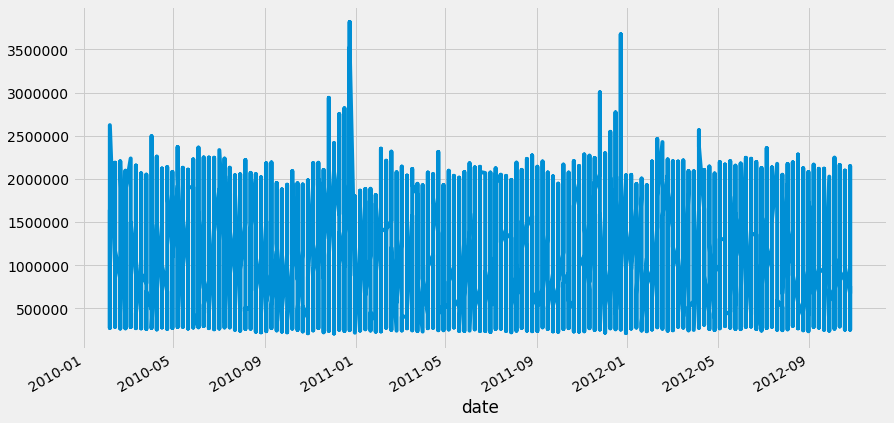

In [19]:
#lets visulize our data
df.weekly_sales.plot()

<AxesSubplot:xlabel='date'>

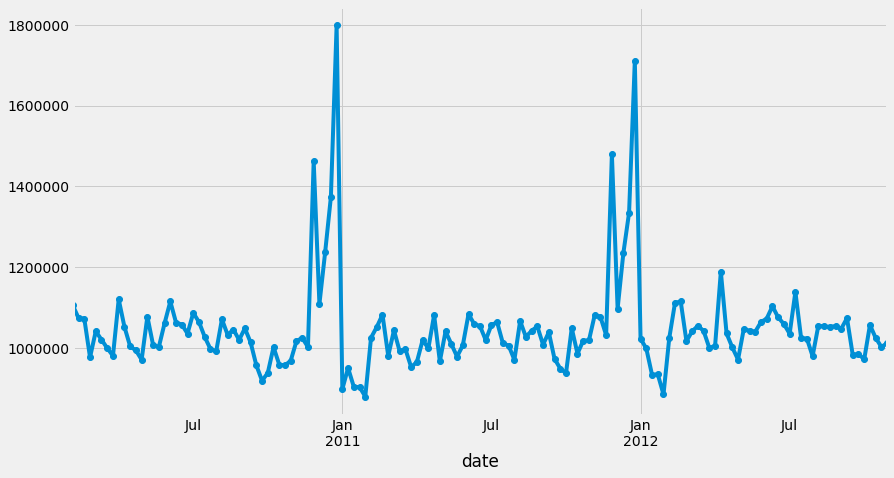

In [20]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('W').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

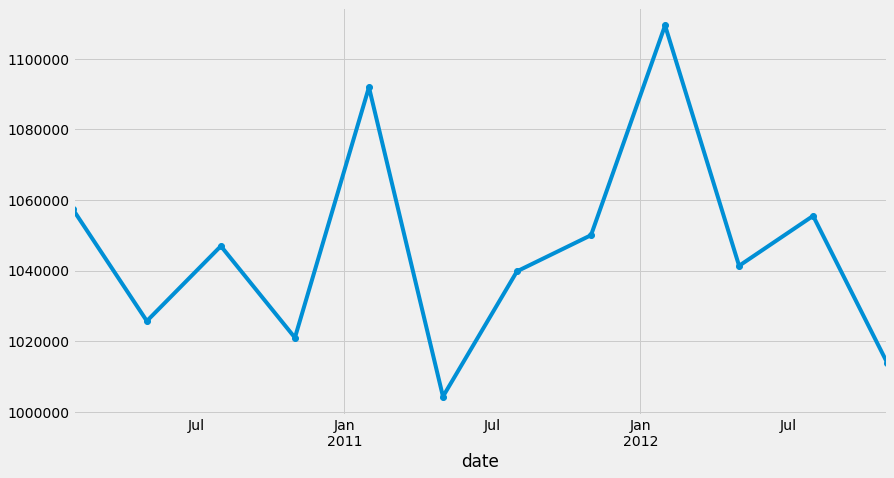

In [21]:
#  let's visualize Theden by quarter# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('3M').mean().plot(marker='o')

<AxesSubplot:xlabel='date'>

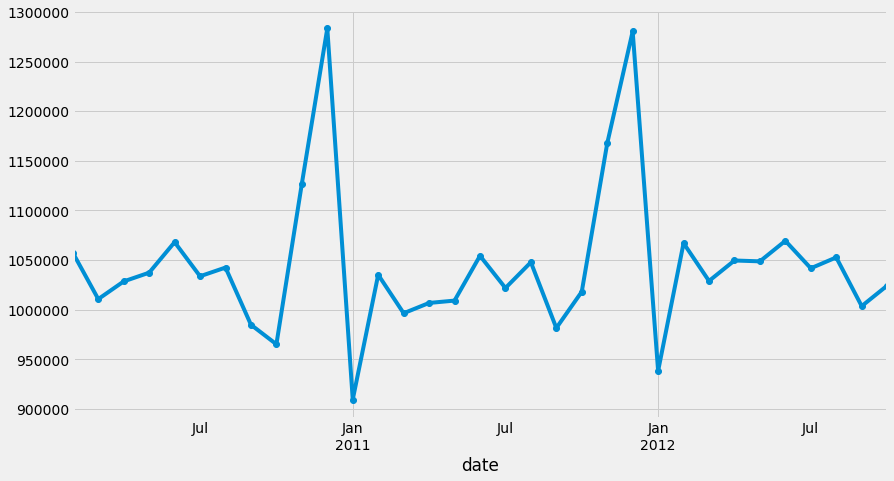

In [22]:
# Lets resomaple our data into monthly vlaues
df.weekly_sales.resample('M').mean().plot(marker='o')

,weekly_sales,rolling_3,rolling_5,rolling_7
date,,,,
2010-02-07,1.105572e+06,NaN,NaN,NaN
2010-02-14,1.074148e+06,NaN,NaN,NaN
2010-02-21,1.072822e+06,1.084181e+06,NaN,NaN
2010-02-28,9.770794e+05,1.041350e+06,NaN,NaN
2010-03-07,1.041588e+06,1.030497e+06,1.054242e+06,NaN
2010-03-14,1.020564e+06,1.013077e+06,1.037240e+06,NaN
2010-03-21,9.997550e+05,1.020636e+06,1.022362e+06,1.041647e+06
2010-03-28,9.807547e+05,1.000358e+06,1.003948e+06,1.023816e+06
2010-04-04,1.120530e+06,1.033680e+06,1.032638e+06,1.030442e+06


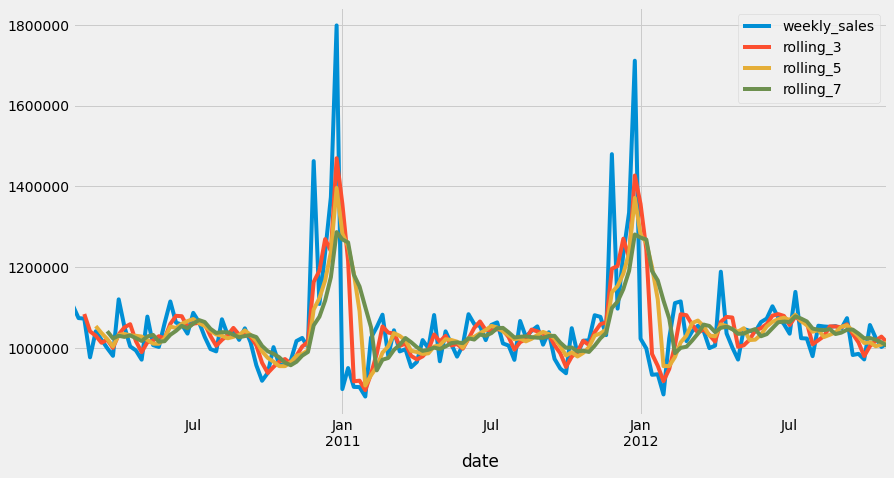

In [23]:
# Rolling Averages every week
rolling_df = df.resample('w').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)
# Delete colums to see targets rolling averages in 2 wweks, a month and quarterly
# Del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

,weekly_sales,rolling_3,rolling_5,rolling_7
date,,,,
2010-02-07,1.105572e+06,NaN,NaN,NaN
2010-02-21,1.073485e+06,NaN,NaN,NaN
2010-03-07,1.009334e+06,1.062797e+06,NaN,NaN
2010-03-21,1.010160e+06,1.030993e+06,NaN,NaN
2010-04-04,1.050642e+06,1.023379e+06,1.049839e+06,NaN
2010-04-18,1.028322e+06,1.029708e+06,1.034389e+06,NaN
2010-05-02,9.826620e+05,1.020542e+06,1.016224e+06,1.037168e+06
2010-05-16,1.042592e+06,1.017859e+06,1.022876e+06,1.028171e+06
2010-05-30,1.031973e+06,1.019076e+06,1.027238e+06,1.022241e+06


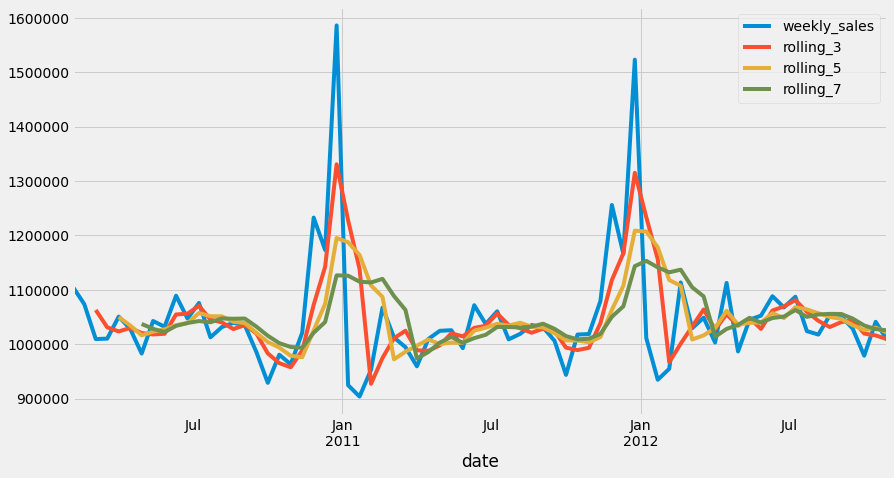

In [24]:
# Rolling Averages for dara downsampled to every 2 weeks 
rolling_df = df.resample('2W').mean().assign(
    rolling_3=lambda df: df.weekly_sales.rolling(3).mean(),
    rolling_5=lambda df: df.weekly_sales.rolling(5).mean(),
    rolling_7=lambda df: df.weekly_sales.rolling(7).mean(),
)

# delete colums to see targets rolling averages in 2 wweks, a month and quarterly
# del rolling_df['weekly_sales']
del rolling_df['store']
del rolling_df['holiday_flag']
del rolling_df['temperature']
del rolling_df['fuel_price']
del rolling_df['consumer_price_index']
del rolling_df['unemployment']
rolling_df.plot()
rolling_df.head(20)

In [25]:
df.sample()

,store,weekly_sales,holiday_flag,temperature,fuel_price,consumer_price_index,unemployment
date,,,,,,,
2011-08-26,21,821127.53,0,92.07,3.523,215.386897,7.852


## Takeaways
- Our data comes from the sales of *143 weeks* for *45 stores* 
    - Data set is just shy of three years
- Our data runs from **'2010-01-10'** to **'2012-12-10'**
- Walmart seems to experience seasonality around the months of November and December
- There are a lot of gaps in daily data
-  Data does not seem to be arranged daily
    - Farther explore how data is arranged 
        - Data sales runs weekly per store


# Split

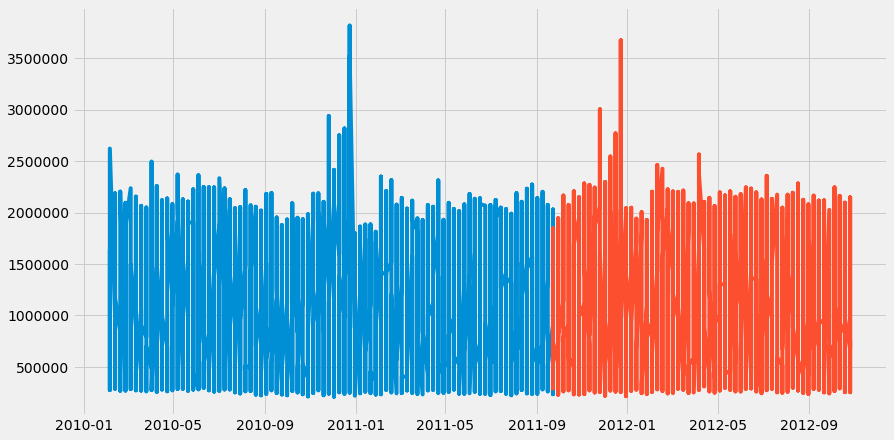

In [26]:
# Use percentage methodes to split
train_size = .60
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.weekly_sales)
plt.plot(test.index, test.weekly_sales)

In [27]:
# eliminate all variables from train and test exept target 
train = pd.DataFrame(train['weekly_sales'])
test = pd.DataFrame(test['weekly_sales'])


In [28]:
# Establish taget 
y = df.weekly_sales
y.head(), y.shape

(date
 2010-02-05    1643690.90
 2010-02-05    2193048.75
 2010-02-05     536006.73
 2010-02-05     789036.02
 2010-02-05     465108.52
 Name: weekly_sales, dtype: float64,
 (6435,))

# EDA After Split

<AxesSubplot:ylabel='Frequency'>

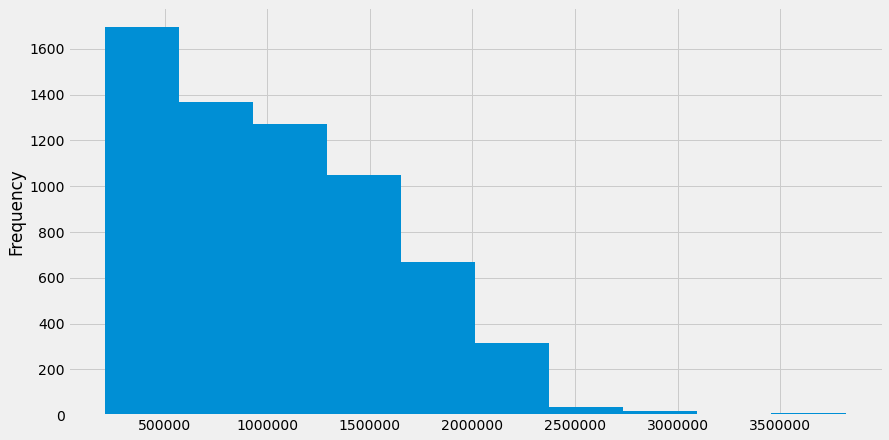

In [29]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Sales by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Sales $US')]

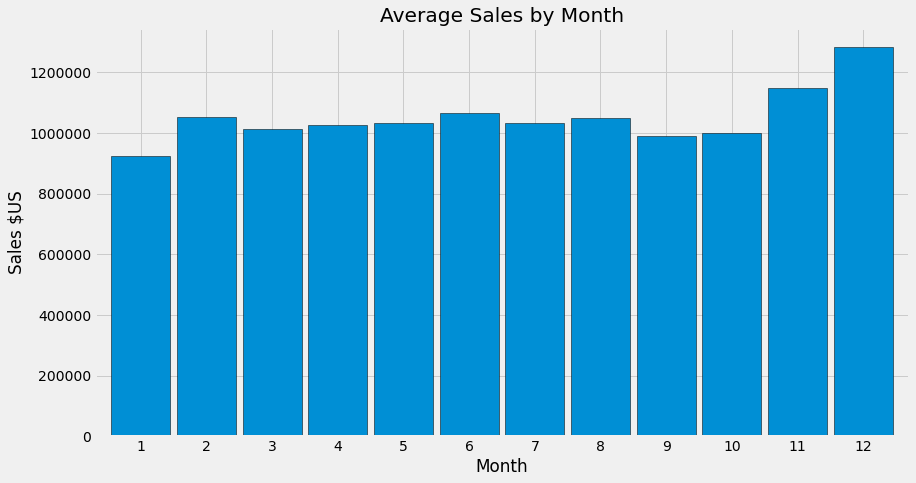

In [30]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Sales by Month', xlabel='Month', ylabel='Sales $US')

[Text(0.5, 1.0, 'Average Sales by Week'),
 Text(0.5, 0, 'Week number'),
 Text(0, 0.5, '$US')]

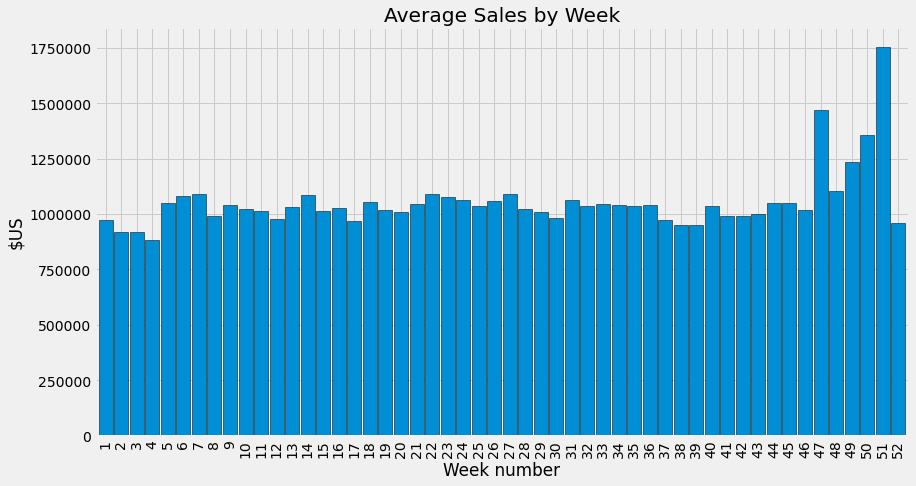

In [31]:
ax = y.groupby(y.index.week).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Sales by Week', xlabel='Week number', ylabel='$US')



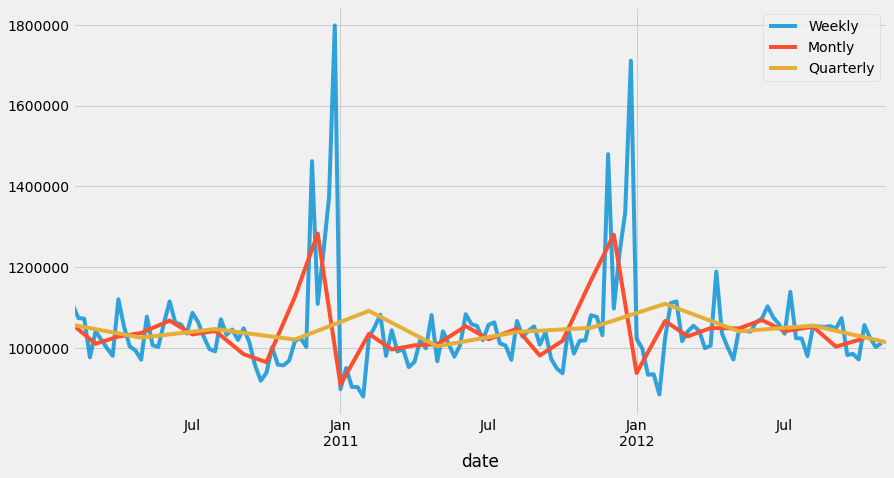

In [32]:
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('3M').mean().plot(label='Quarterly')
plt.legend()


- Seasonality is evident for November, December, and January
- Normal distribution can be observed
- Week 47 shows seasonality 
- From the first week of February, sales start to pick up
- Second-quarter seems to have a drop in sales to pick up in summer

--------------

# Modeling/ Forecasting

The following functions will help evaluate each of the forecasting methods.

In [33]:
train.columns

Index(['weekly_sales'], dtype='object')

In [34]:
def plot_samples(target_var):
    '''
    This function will plot the train and test values for a single variable across all dates. 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

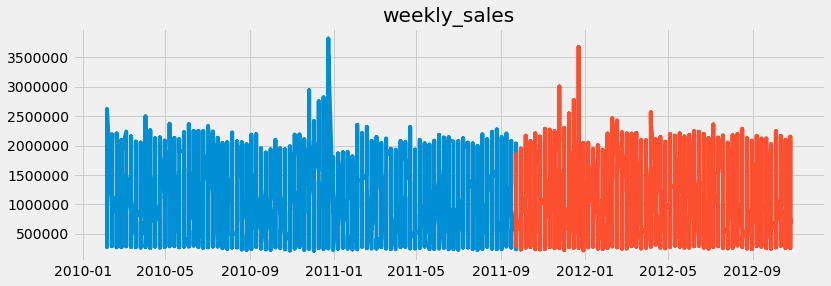

In [35]:
# plot the data points, color by train, validate, test
# col = 'weekly_sales'
for col in train.columns:
    plot_samples(col)

plt.show()

In [36]:
# evaluation function to compute rmse
def evaluate(target_var):
    """
    Function will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.
    """
    rmse = round(sqrt(mean_squared_error(train[target_var], yhat_df[target_var])), 0)
    return rmse

In [37]:
# plot and evaluate 
def plot_and_eval(target_var):
    """
    Function will plot train and test values with the predicted
    values to compare performance.
    """
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.0f}'.format(rmse))
    plt.show()

In [38]:
# Create an empty data frame where all the results of the models will go  
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [39]:
# Check eval_df
type(eval_df)

pandas.core.frame.DataFrame

In [40]:
# Function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    """
    Append evaluation metrics for each model type, target variable, and metric 
    type, along with the metric value, into our eval_df data frame object. Which 
    we will create an empty eval_df data frame object to start.
    """
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last Observed Value
Predicts all future values to be the last observed value.

### Forecasting predictions

In [41]:
# Predicions
# create var 'weekly_sales' with last observed value
weekly_sales = train['weekly_sales'][-1]
weekly_sales


1380020.27

In [42]:
# make predictions by adding weekly_sales to new dataframe yhat_df
yhat_df = pd.DataFrame({'weekly_sales' : [weekly_sales]}, 
                       index = train.index)

yhat_df.head(2)

,weekly_sales
date,
2010-02-05,1380020.27
2010-02-05,1380020.27


weekly_sales --RMSE: 655762


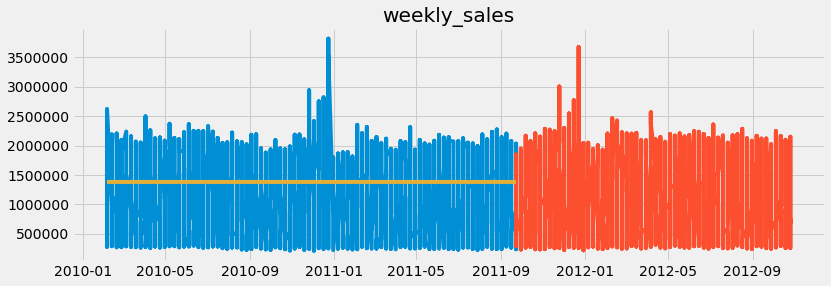

In [43]:
for col in train.columns:
    plot_and_eval(col)

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

In [45]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,weekly_sales,655762.0


# Simple Average
Take the simple average of historical values and use that value to predict future values.

- Good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.


In [46]:
# Predicions
# create var 'weekly_sales' with last observed value
weekly_sales = round(train['weekly_sales'].mean(), 2)

def make_predictions(weekly_sales):
    yhat_df = pd.DataFrame({'weekly_sales': [weekly_sales]}, index = train.index)
    return yhat_df

In [47]:
yhat_df = make_predictions(weekly_sales)
yhat_df

,weekly_sales
date,
2010-02-05,1037252.28
2010-02-05,1037252.28
2010-02-05,1037252.28
2010-02-05,1037252.28
2010-02-05,1037252.28
...,...
2011-09-23,1037252.28
2011-09-23,1037252.28
2011-09-23,1037252.28


weekly_sales --RMSE: 559047


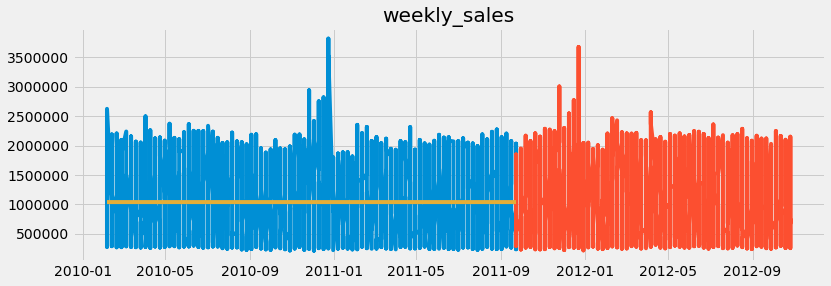

In [48]:
# Plot Actual vs. Predicted Values 
# Evaluate the performance of our time series model using Simple Average
for col in train.columns:
    plot_and_eval(col)

In [49]:
# Evaluate using MSE and RMSE, and add evaluation metrics to eval_df
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [50]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,weekly_sales,655762.0
1,simple_average,weekly_sales,559047.0


## Moving Average
We will use a 4 weeks moving average to forecast. In other words, the average over the last month will be used as the forecasted value.

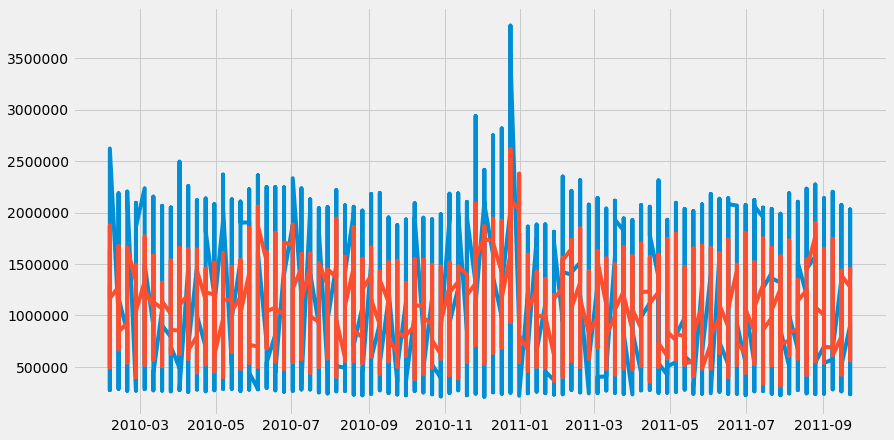

In [51]:
# Predicions 
plt.plot(train['weekly_sales'])
plt.plot(train['weekly_sales'].rolling(4).mean())

In [52]:
period = 4

# use the rolling method, take the rolling mean of 120 weeks, and select the last value, i.e. the last day in train. 
# round to 2 decimals
weekly_sales = round(train['weekly_sales'].rolling(period).mean().iloc[-1], 2)

print(weekly_sales)

1349143.01


In [53]:
# create a new yhat data frame with the forecast through test dates
yhat_df = make_predictions(weekly_sales)
yhat_df.head(3)

,weekly_sales
date,
2010-02-05,1349143.01
2010-02-05,1349143.01
2010-02-05,1349143.01


weekly_sales --RMSE: 640164


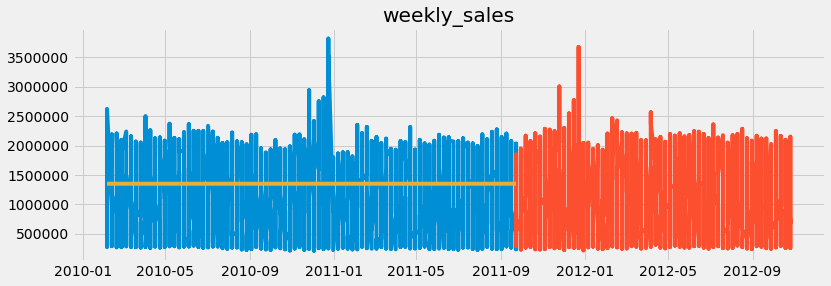

In [54]:
# Plot Actual vs. Predicted Values Using Moving Average
for col in train.columns:
    plot_and_eval(col)

In [55]:
# append the evaluation results to our eval_df for each target variable so we can compare. 
for col in train.columns:
    eval_df = append_eval_df(model_type = '4_weeks_moving_average', target_var = col)

In [56]:
yhat_df

,weekly_sales
date,
2010-02-05,1349143.01
2010-02-05,1349143.01
2010-02-05,1349143.01
2010-02-05,1349143.01
2010-02-05,1349143.01
...,...
2011-09-23,1349143.01
2011-09-23,1349143.01
2011-09-23,1349143.01


weekly_sales --RMSE: 560215


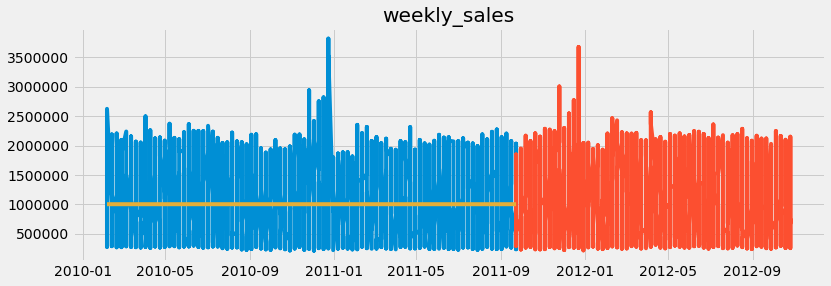

In [57]:
period = 52

# use the rolling method, take the rolling mean of 52 week, and select the last value, i.e. the last week in train. 
# round to 2 decimals
weekly_sales = round(train['weekly_sales'].rolling(period).mean().iloc[-1], 2)

# create a new yhat data frame with the forecast through test dates
yhat_df = make_predictions(weekly_sales)

# append results to the eval_df
# plot the forecasts
for col in train.columns:
    eval_df = append_eval_df(model_type = '52_weeks_moving_average', target_var = col)
    plot_and_eval(col)
    

In [58]:
yhat_df

,weekly_sales
date,
2010-02-05,1001103.1
2010-02-05,1001103.1
2010-02-05,1001103.1
2010-02-05,1001103.1
2010-02-05,1001103.1
...,...
2011-09-23,1001103.1
2011-09-23,1001103.1
2011-09-23,1001103.1


weekly_sales --RMSE: 577333


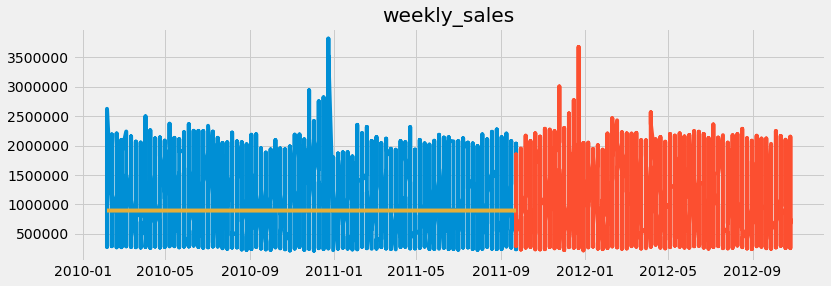

In [59]:
period = 104

# use the rolling method, take the rolling median of 120 week, and select the last value, i.e. the last day in train. 
# round to 2 decimals
weekly_sales = round(train['weekly_sales'].rolling(period).median().iloc[-1], 2)

# create a new yhat data frame with the forecast through test dates
yhat_df = make_predictions(weekly_sales)

# append results to the eval_df
# plot the forecasts
for col in train.columns:
    eval_df = append_eval_df(model_type = '104_weeks_moving_median', target_var = col)
    plot_and_eval(col)
    

In [60]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,weekly_sales,655762.0
1,simple_average,weekly_sales,559047.0
2,4_weeks_moving_average,weekly_sales,640164.0
3,52_weeks_moving_average,weekly_sales,560215.0
4,104_weeks_moving_median,weekly_sales,577333.0


weekly_sales --RMSE: 579131


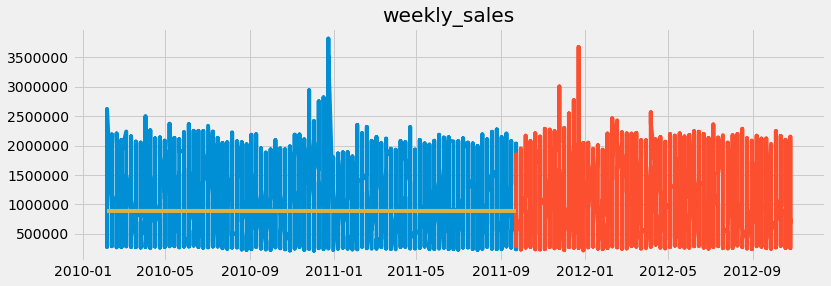

In [61]:
period = 52

# use the rolling method, take the rolling median of 52 weeks, and select the last value, i.e. the last day in train. 
# round to 2 decimals
weekly_sales = round(train['weekly_sales'].rolling(period).median().iloc[-1], 2)

# create a new yhat data frame with the forecast through test dates
yhat_df = make_predictions(weekly_sales)

# append results to the eval_df
# plot the forecasts
for col in train.columns:
    eval_df = append_eval_df(model_type = '52_weeks_moving_median', target_var = col)
    plot_and_eval(col)

In [62]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,weekly_sales,655762.0
1,simple_average,weekly_sales,559047.0
2,4_weeks_moving_average,weekly_sales,640164.0
3,52_weeks_moving_average,weekly_sales,560215.0
4,104_weeks_moving_median,weekly_sales,577333.0
5,52_weeks_moving_median,weekly_sales,579131.0


In [63]:
""" 
Calculates the moving Average for multiple piriods of time
"""

periods = [1, 16, 26, 42]

for p in periods:
    # use the rolling method, take the rolling mean of 1, 16, 26, and 42 weeks, and select the last value, i.e. the last day in train. 
    # round to 2 decimals
    weekly_sales = round(train['weekly_sales'].rolling(p).mean().iloc[-1], 2)

    # create a new yhat data frame with the forecast through test dates
    yhat_df = make_predictions(weekly_sales)

    # append results to the eval_df
    # plot the forecasts
    model_type = str(p) + '_week_moving_average'
    eval_df = append_eval_df(model_type = model_type, target_var = 'weekly_sales')

In [64]:
""" 
Calculates the moving Mean for multiple piriods of time
"""

periods = [1, 16, 26, 42]

for p in periods:
    # use the rolling method, take the rolling mean of 1, 16, 26, and 42 weeks, and select the last value, i.e. the last day in train. 
    # round to 2 decimals
    weekly_sales = round(train['weekly_sales'].rolling(p).median().iloc[-1], 2)

    # create a new yhat data frame with the forecast through test dates
    yhat_df = make_predictions(weekly_sales)

    # append results to the eval_df
    # plot the forecasts
    model_type = str(p) + '_week_moving_median'
    eval_df = append_eval_df(model_type = model_type, target_var = 'weekly_sales')

In [65]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,weekly_sales,655762.0
1,simple_average,weekly_sales,559047.0
2,4_weeks_moving_average,weekly_sales,640164.0
3,52_weeks_moving_average,weekly_sales,560215.0
4,104_weeks_moving_median,weekly_sales,577333.0
5,52_weeks_moving_median,weekly_sales,579131.0
6,1_week_moving_average,weekly_sales,655762.0
7,16_week_moving_average,weekly_sales,559610.0
8,26_week_moving_average,weekly_sales,559852.0
9,42_week_moving_average,weekly_sales,560229.0


## Modeling Conclusion
### Which model did the best?

In [66]:
########### Calculate Best so Far ##############

# get the min rmse for each variable
min_rmse_weekly_sales = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_weekly_sales))]

,model_type,target_var,rmse
1,simple_average,weekly_sales,559047.0


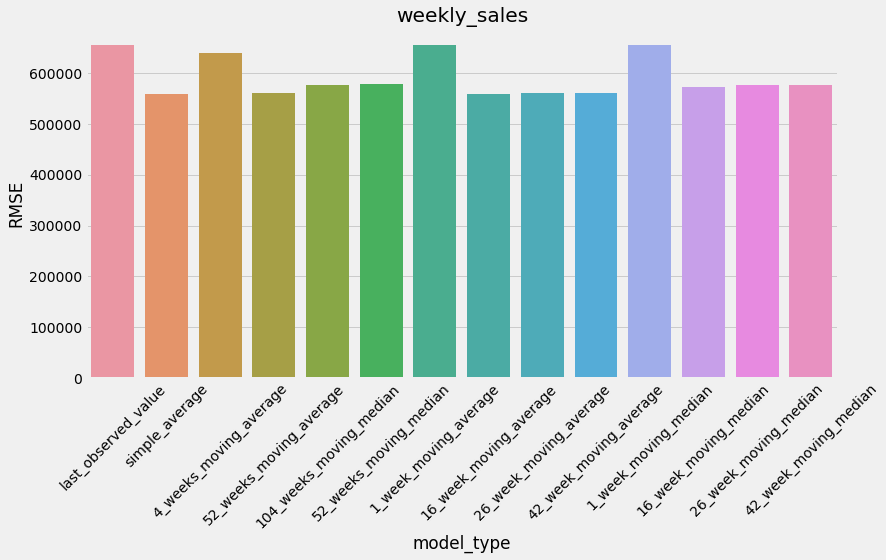

In [67]:
# Plot the RMSE of all models 
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

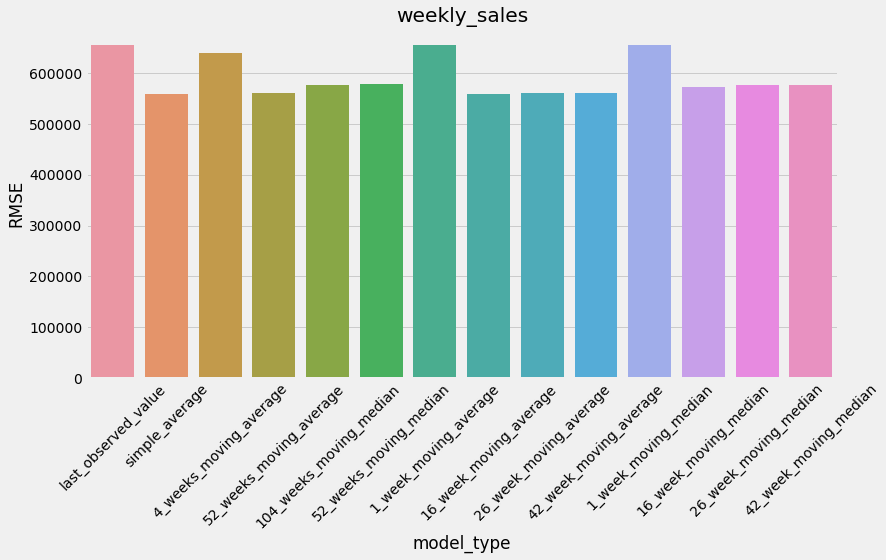

In [68]:
for col in test.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

# Takeawya:
The lower the RMSE, the better the mode. Also, provided the model should have close proximity with the training & testing scores. It can be said that simple average time series model gave us the best results.

## Let's test it out on our out-of-sample data

In [69]:
# Must use the same parameters we used from train
yhat_df = test + train.diff(365).mean()
# Set index to that of test
yhat_df.index = test.index

In [70]:
rmse_weekly_sales = round(sqrt(mean_squared_error(test['weekly_sales'], yhat_df['weekly_sales'])), 0)


In [71]:
# Plot and evaluate train, and test
def plot_and_eval_test(target_var):
    plt.plot(train[target_var], label = 'Train', linewidth = 3, alpha = .8)
    plt.plot(test[target_var], label = 'Test', linewidth = 5)
    plt.plot(yhat_df[target_var], alpha = .5, color="blue")
    plt.title(target_var)
    plt.legend()
    plt.show()

rmse - weekly_sales:  1694.0


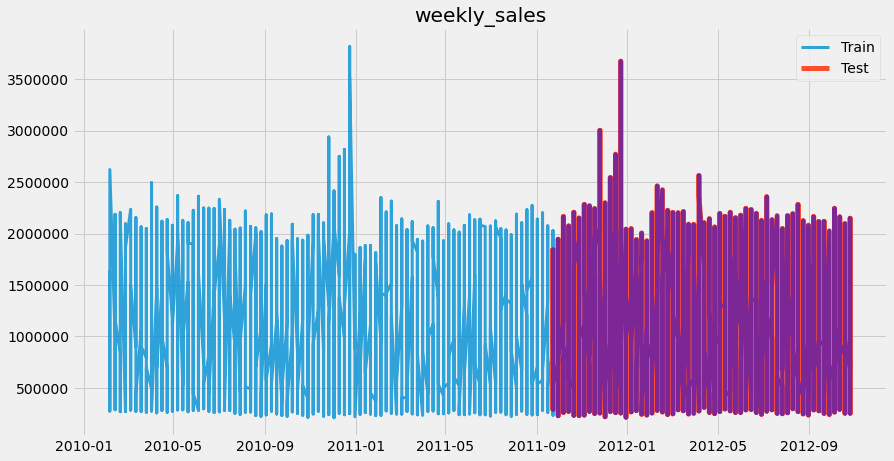

In [72]:
print("rmse - weekly_sales: ", rmse_weekly_sales)

for col in test.columns:
    plot_and_eval_test(col)